In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import altair as alt

print(f"tensorflow: {tf.__version__}")
print(f"keras: {tf.keras.__version__}")

tensorflow: 2.0.0-beta1
keras: 2.2.4-tf


## Building a classifier
First we will load the data for samples for which we have the most data and only the controls and chemically perturbed.

In [2]:
from deep_lincs import Dataset

pert_types = [
    "trt_cp",       # treated with compound
    "ctl_vehicle",  # control for compound treatment (e.g DMSO)
    "ctl_untrt",    # untreated samples
]

cell_ids = [
    "VCAP",
    "MCF7",
    "PC3",
    "A549",
    "A375",
    "HT29",
    "HA1E",
    "HCC515",
    "HEPG2",
    "NPC",
    "ASC",
    "NEU",
]

dataset = Dataset.from_yaml("settings.yaml", pert_type=pert_types, cell_id=cell_ids)
dataset.normalize_by_gene(normalizer="standard_scale")
dataset

<L1000 Dataset: (samples: 627,403, genes: 978)>

Next we can examine the frequency of each metadata field in our dataset.

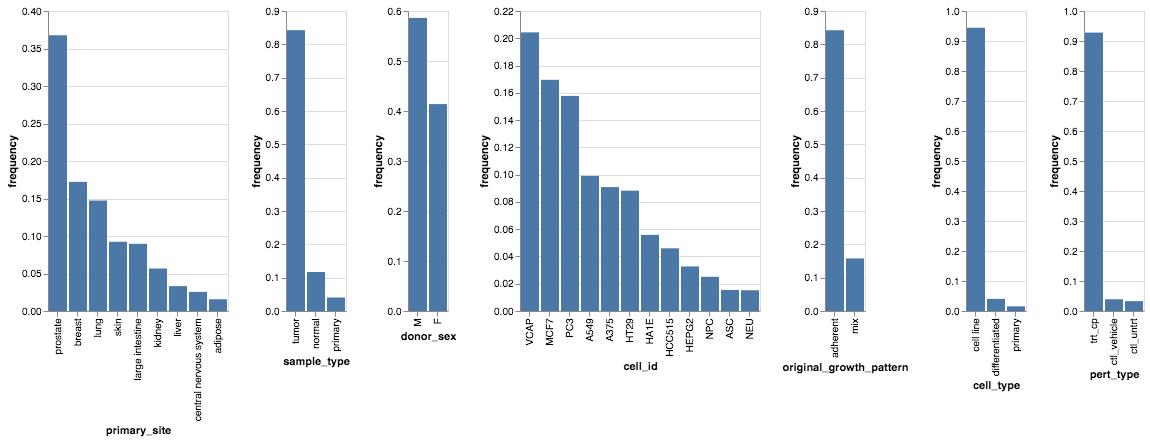

In [3]:
fields = [
    "primary_site",
    "sample_type",
    "donor_sex",
    "cell_id",
    "original_growth_pattern",
    "cell_type",
    "pert_type",
]
alt.hconcat(*[dataset.plot_meta_counts(field) for field in fields])

## Cell classifier
To build a classifier, we will load the `SingleClassifier` class and define a target.

In [4]:
from deep_lincs.models import SingleClassifier
target = "pert_type"
sc = SingleClassifier(dataset, target=target)

Now that we have loaded our data into the classifier and defined a target, we will need to prepare the dataset for training and compile our model. The `SingleClassifier.compile_model()` method takes a list of integers as an argument to define the number of hidden layers and sizes of each layer.

In [5]:
sc.prepare_tf_datasets(batch_size=64)
sc.compile_model([256, 128, 64])
sc.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout (Dropout)            (None, 978)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               250624    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0

In [6]:
sc.fit(epochs=5)

Epoch 1/5


W0729 10:41:28.755558 139854333654848 deprecation.py:323] From /Users/manz01/miniconda3/envs/lincs-gpu/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


6274/6274 [==============================] - 24s 4ms/step - loss: 0.2526 - accuracy: 0.9376 - val_loss: 0.2166 - val_accuracy: 0.9442
Epoch 2/5
6274/6274 [==============================] - 21s 3ms/step - loss: 0.2179 - accuracy: 0.9456 - val_loss: 0.2538 - val_accuracy: 0.9337
Epoch 3/5
6274/6274 [==============================] - 22s 4ms/step - loss: 0.2066 - accuracy: 0.9481 - val_loss: 0.1978 - val_accuracy: 0.9500
Epoch 4/5
6274/6274 [==============================] - 22s 4ms/step - loss: 0.2036 - accuracy: 0.9491 - val_loss: 0.1919 - val_accuracy: 0.9519
Epoch 5/5
6274/6274 [==============================] - 23s 4ms/step - loss: 0.1993 - accuracy: 0.9498 - val_loss: 0.2031 - val_accuracy: 0.9523


In [7]:
sc.evaluate()

1961/1961 [==============================] - 3s 2ms/step - loss: 0.2040 - accuracy: 0.9519


[0.20400989416194534, 0.95185727]

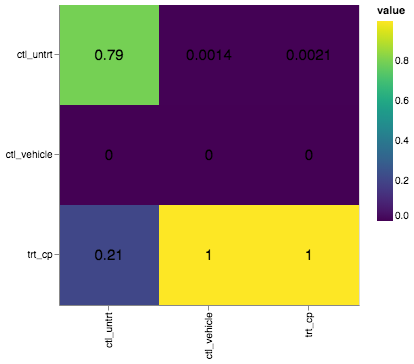

In [8]:
sc.plot_confusion_matrix()

## Multi-Classifier

For a multiple classifier, we will need to pick multiple targets and pass these to the constructor of the `MultiClassifier` class.

In [9]:
from deep_lincs.models import MultiClassifier
targets = ["cell_id", "primary_site", "sample_type", "original_growth_pattern", "pert_type"]
dataset.dropna("primary_site", inplace=True)
mc = MultiClassifier(dataset, targets=targets)

In [10]:
mc.prepare_tf_datasets(batch_size=64)
mc.compile_model([256, 128, 64])
mc.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 978)]        0                                            
__________________________________________________________________________________________________
dropout_4 (Dropout)             (None, 978)          0           input_1[0][0]                    
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 256)          250624      dropout_4[0][0]                  
__________________________________________________________________________________________________
dropout_5 (Dropout)             (None, 256)          0           dense_4[0][0]                    
______________________________________________________________________________________________

In [11]:
mc.fit(epochs=10)

Epoch 1/10
6178/6178 [==============================] - 37s 6ms/step - loss: 0.4172 - cell_id_loss: 0.0632 - primary_site_loss: 0.0600 - sample_type_loss: 0.0158 - original_growth_pattern_loss: 0.0110 - pert_type_loss: 0.2673 - cell_id_accuracy: 0.9859 - primary_site_accuracy: 0.9857 - sample_type_accuracy: 0.9955 - original_growth_pattern_accuracy: 0.9969 - pert_type_accuracy: 0.9337 - val_loss: 0.3150 - val_cell_id_loss: 0.0269 - val_primary_site_loss: 0.0236 - val_sample_type_loss: 0.0022 - val_original_growth_pattern_loss: 0.0037 - val_pert_type_loss: 0.2586 - val_cell_id_accuracy: 0.9952 - val_primary_site_accuracy: 0.9955 - val_sample_type_accuracy: 0.9995 - val_original_growth_pattern_accuracy: 0.9987 - val_pert_type_accuracy: 0.9352
Epoch 2/10
6178/6178 [==============================] - 33s 5ms/step - loss: 0.2663 - cell_id_loss: 0.0202 - primary_site_loss: 0.0202 - sample_type_loss: 0.0026 - original_growth_pattern_loss: 0.0039 - pert_type_loss: 0.2193 - cell_id_accuracy: 0.9

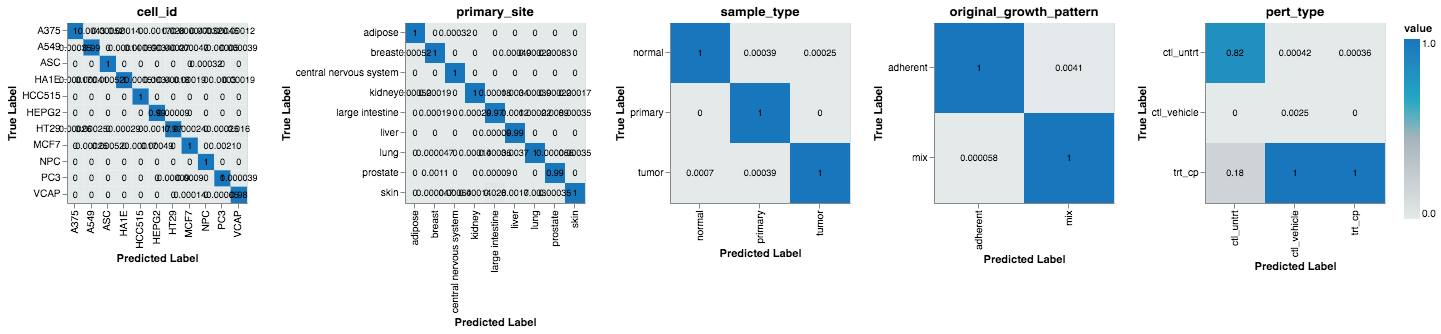

In [12]:
mc.plot_confusion_matrix(size=180)